# 4. Technical notebook for Movielens engine recommendation 

In this delivery I will attempt to answer the question “What movie should I watch this evening?” by modelling MovieLens data.

# Exploratory analysis summary

Our main variables are ratings, genres, movie titles and users.

Ratings tend to be quite positive overall. Different variables other than the quality of movies could be impacting user's ratings.

The most popular movie genres are Drama, Comedy, Action, Thriller, and Romance.
The top five most watch movie titles are:

American Beauty (1999) 
Jurassic Park (1993) 
Saving Private Ryan (1998) 
Matrix, The (1999) 
Back to the Future (1985)

The demographic profile of our users is mainly males, aged 18 - 44 years old, working in a variety of occupations (e.g. students, professionals, academics and technicians) and located across US states.

# Modelling approach

We could be exploring different types of approaches for our movie recommendation as per James Lee blog post: 
https://medium.com/@james_aka_yale/the-4-recommendation-engines-that-can-predict-your-movie-tastes-bbec857b8223

Types of Recommendation Engines we could explore as per James Lee blog post are:

1. Content-Based

Benefits:
Easy to implement due to no training or optimization is involved.
No need for data on other users, thus no cold-start or sparsity problems.
Can recommend to users with unique tastes.
Can recommend new & unpopular items.
Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

Drawbacks:
Finding the appropriate features is hard.
Does not recommend items outside a user’s content profile.
Unable to exploit quality judgments of other users.
Model performance decrease when having sparse data which hinders scalability of approach.



2. Memory-Based Collaborative Filtering

Benefits:
Easy to implement due to no training or optimization is involved
Reasonable prediction quality.

Drawbacks:
It doesn't address the cold-start problem, that is when new user or new item enters the system.
It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
It suffers when new users or items that don't have any ratings enter the system.
It tends to recommend popular items.
It doesn’t scale particularly well to massive datasets, especially for real-time recommendations based on user behavior similarities — which takes a lot of computations.
Ratings matrices may be overfitting to noisy representations of user tastes and preferences. 



3. Model-Based Collaborative Filtering (based on Matrix Factorization)

The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. James Less applied Dimensionality Reduction techniques to derive the tastes and preferences from the raw data and Singular Vector Decomposition (SVD)

Why reduce dimensions?
We can discover hidden correlations / features in the raw data.
We can remove redundant and noisy features that are not useful.
We can interpret and visualize the data easier.
We can also access easier data storage and processing.

Benefits:
Widely used for recommender systems 
It deals better with scalability and sparsity than Memory-based CF 
   
Drawbacks:
Singular Vector Decomposition (SVD) is an outdates methodology and would be better using newer factorisation methods.
Some of those could be PCA or Non-Negative Matrix Factorisation because they build on SVD. 


4. Deep Learning / Neural Network

Similar to that of Model-Based Matrix Factorization. The sparse matrix doesn't need to be orthogonal. 
We want our model to learn the values of embedding matrix itself. The user latent features and movie latent features are looked up from the embedding matrices for specific movie-user combination. These are the input values for further linear and non-linear layers. We can pass this input to multiple relu, linear or sigmoid layers and learn the corresponding weights by any optimization algorithm 

Benefits:
This model performed better than all the approaches James Lee attempted before. 

Drawbacks:
High computer performance needed
Important investment of time needed in tunning the model
Highly complex model with difficulty for troubleshooting 
Last lesson of this course which means no practical knowledge of methodology as yet


After researching on what's the best approach for our model considering the project and data set constrains I decided to implement a recommendation engine that doesn't consider users ratings because the variable is not always available and I would like the model to be as replicable as possible in other scenarios. My aim is to make meaninful movie recommendations in this case with the least user information needed so we can reuse our model in other contexts (e.g. recommend unrated events on a different website)

For this, I will attempt to use the Latent Dirichlet Allocation (LDA) modelling method.

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's creation is attributable to one of the document's topics. LDA is an example of a topic model. Source: https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

My goal is grouping the movie titles watched into themes so recommendations are generated based on top movies within a specific theme that the user hasn't watched yet.

Therefore, I expect my model to be similar to James Lee's Model-Based Collaborative Filtering but using a more sophisticated method as LDA is meant to be. I am also inpiring my project on the New York Times recommendation engine blog post located here:
https://open.blogs.nytimes.com/2015/08/11/building-the-next-new-york-times-recommendation-engine/?_r=0

Benefits:
Widely used for recommender systems. LDA is central to topic modeling and has really revolutionized the field
LDA tends to perform well on small datasets because Bayesian methods can avoid overfitting the data
It deals better with scalability and sparsity than Memory-based CF 
LDA is a probabilistic model with interpretable topics
LDA gives you categories for free, in any data set

Drawbacks:
It's hard to know when LDA is working becasue themes are soft-clusters so there is no objective metric to say "this is the best choice" of hyperparameters
Fixed K (the number of themes is fixed and must be known ahead of time)
Uncorrelated topics (Dirichlet theme distribution cannot capture correlations)
Non-hierarchical (in data-limited regimes hierarchical models allow sharing of data)
Static (no evolution of themes over time)
Bag of words (assumes words are exchangeable, sentence structure is not modeled)
Unsupervised (sometimes weak supervision is desirable, e.g. in sentiment analysis)
The accuracy of statistical inference (which is the base of LDA) depends on the number of observations.

I will be using the "Single Variable Strategy" in my approach meaning that I will start with the most important variable and slowly add in while paying attention to the model's performance if scope allows for it. My variables of choice are Movie titles users. 

# Data transformations needed pre modelling

In [105]:
#imports
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pylab as pl
import numpy as np
import seaborn as sns
%matplotlib inline
import gensim
import spacy
nlp_toolkit = spacy.load("en")

## Load spacy
import spacy

# Setting up spacy
nlp = spacy.load('en')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

#Regular expressions
import regex as re

# Gensim is used for LDA (and other models)
from gensim.models.ldamulticore import LdaModel
from gensim.matutils import Sparse2Corpus

# Setting up spacy
nlp = spacy.load('en')

In [183]:
# Bringing in movie frequency data (unpickling my moviewatchedrank dataframe)
unpickled_moviewatchedrank = pd.read_pickle('moviefreq.pkl')

#Reassigning
movie_freq = unpickled_moviewatchedrank
movie_freq.head()



,MovieID,Users_count
2651,2858,3428
466,480,2672
1848,2028,2653
2374,2571,2590
1178,1270,2583


In [184]:
# Bringing in rest of data (unpickling my dfc dataframe)
unpickled_dfc = pd.read_pickle('dfc.pkl')

#Reassigning
dfc = unpickled_dfc
dfc.head()

,UserID,MovieID,Rating,Timestamp,Title,Genres,Gender,Age,Occupation,Zip-code
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,978824291,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [202]:
#Swapping MovieIDs (movie_freq) for Movie titles (dfc)
movie_freq1 = movie_freq.join(dfc.Title, on='MovieID',how='inner', lsuffix='movie_freq', rsuffix='', sort=False)
movie_freq1.head()

#Re ordering my columns and sorting by users count descending
titles_freq = movie_freq1.reindex (columns=['MovieID','Title','Users_count'])
titles_freqc = titles_freq.sort_values('Users_count', ascending=False)
titles_freqc.head()


,MovieID,Title,Users_count
2651,2858,"Misérables, Les (1998)",3428
466,480,Superman (1978),2672
1848,2028,Babes in Toyland (1961),2653
2374,2571,"Brady Bunch Movie, The (1995)",2590
1178,1270,Four Weddings and a Funeral (1994),2583


# Latent variable modelling with LDA

# Pending

_Latent variable models_ are different in that instead of attempting to recreate rules of language, we'll try to understand language based on **how** the words are used. For example, we won't attempt to learn that 'bad' and 'badly' are related because they share the same root, but instead we'll determine that they are related because they are often used in the same way often or near the same words.

We'll use _unsupervised_ learning techniques (discovering patterns or structure) to extract the information.

Rather than inferring that 'Python' and 'C++' are both programming languages because they are often a noun preceded by the verb 'program' or 'code', we'll infer a category by identifying that they are often used in the same way. We won't need to guide them with particular phrases to look for parts of speech.

# Pending

_Latent variable models_ are models in which we assume that the data we are observing has some hidden, underlying structure that we can't see, and which we'd like to learn. These hidden, underlying structure are the _latent_ variables we want our model to understand.

Text processing is a common application of latent variable models. Again, in the classical sense we know that language is built by a set of pre-structured grammar rules and vocabulary; however, we also we know that we break those rules pretty often and create new words that get added into our vocabulary (see: selfie).

Instead of attempting to learn the rules of 'proper' grammar, we instead look to uncover the hidden structure and ignore preexisting rules (which might not even describe our syntax anyway). Sometimes, the hidden structure we uncover _are_ the basic rules of our language, but sometimes they may also unveil something new.

These techniques are commonly used for recommending news articles or mining large troves of data data and trying to find commonalities. Topic modeling, a method we will discuss in today's class, is used in the [NY times recommendation engine](http://open.blogs.nytimes.com/2015/08/11/building-the-next-new-york-times-recommendation-engine/?_r=0). They attempt to map their articles to a latent space (or underlying structure) of topics using the content of the article.

[Lyst](http://developers.lyst.com/2014/11/11/word-embeddings-for-fashion/), an online fashion retailer, uses latent representations of clothing descriptions to find similar clothing. If we can map phrases like 'chelsea boot' or 'felted hat' to some underlying structure, we can use that new structure to find similar products.

# Pending

Our previous 'representation' of a set of text documents (articles) for classification was a matrix with one row per document and one column per word (or _n-gram_).

![Word Factorization Matrix](./assets/images/word-matrix-factorization.png)

While this does sum up most of the information, it does drop a few things - mostly structure and order. Additionally, many of the columns may be dependent on each other (or correlated).

For example, an article that contains the word 'IPO' is also likely to contain the work 'stock' or 'NASDAQ'.  Therefore, those columns are repetitive and both of those columns likely represent the same 'concept' or idea. For classification, we may not care if the document has the word 'IPO' or 'NASDAQ' or 'stocks', but just that it has financial-related words.

One way to do this is with regularization - `L1` or `lasso` regularization tends to remove repetitive features by bringing their learned coefficients to 0.

Another is to perform `dimensionality reduction` - where we first identify the correlated columns and then replace them with a column that represents the concept they have in common. For instance, we could replace the 'IPO', 'stocks', and 'NASDAQ' column with a single - 'HasFinancialWords' column.

There are many techniques to do this automatically and most follow a very similar approach:

1. Identify correlated columns
2. Replace them with a new column that encapsulates the others

The techniques vary in how they define correlation and how much of the relationship between the original and new columns you need to save.

There are many dimensionality techniques built into `scikit-learn`. One of the most common is **PCA** or **Principal Components Analysis**. Like most of the models we've seen, dimensionality techniques can vary between _linear_ or _non-linear_, meaning that they pick up linear or non-linear correlations between columns.

**PCA** when applied to text data is sometimes known as **LSI** or **Latent Semantic Indexing**.


# Pending

Mixture models (and specifically **LDA** or **Latent Dirichlet Allocation**) take this concept further and generate more structure around the documents. Instead of just replacing correlated columns, we create clusters of common words and generate probability distributions to explicitly state how related words are.

To understand this better, let's imagine a new way to generate text:

1. Start writing a document
    1. First choose a topic (sports, news, science)
        1. Choose a word from that topic
    2. Repeat
2. Repeat for the next document

What this 'model' of text is assuming is that each document is some _mixture_ of topics. It may be mostly science, but may contain some business information. The _latent_ structure we want to uncover are the topics (or concepts) that generated that text.

_Latent Dirichlet Allocation_ is a model that assumes this is the way text is generated and then attempts to learn two things:

    1. What is the _word distribution_ of each topic?
    2. What is the _topic distribution_ of each document?
    
The _word distribution_ is a multinomial distribution for each topic representing what words are most likely from that topic.

Let's say we have 3 topics: sports, business, science.
For each topic, we uncover the words most likely to come from them:

For each word and topic pair, we learn some `P ( word | topic) `

The _topic distribution_ is a multinomial distribution for each document representing which topics are most likely to be in that document. For all documents, we then have a distribution over {sports, science, business}

Topic models are useful for organizing a collection of documents and uncovering the main underlying concepts.

There are many variants as well, that attempt to incorporate more structure into the 'model'

 - Supervised Topic Models
    - Guide the process with pre-decided topics
 - Position-dependent topic models
    - Ignore which words occur in what document but instead focus on _where_ they occur
 - Variable number of topics
    - Test a different number of topics to find the best model

# Pending

- Latent variable models attempt to uncover structure from text.
- Dimensionality reduction is focused on replacing correlated columns.
- Topic modeling (or LDA) uncovers the topics that are most common to each document and then the words most common to those topics.
- Word2Vec builds a representation of a word from the way it was used originally.
- Both techniques avoid learning grammar rules and instead rely on large datasets. They learn based on how the words are used, making them very flexible.

In [203]:
#Removing years from movie titles because there are no movies with more than one release date 
#in my data set so the year info doesn't add any value to my titles

titles_freqc.Title = titles_freqc.Title.str[:-6]
titles_freqc.head()

,MovieID,Title,Users_count
2651,2858,"Misérables, Les",3428
466,480,Superman,2672
1848,2028,Babes in Toyland,2653
2374,2571,"Brady Bunch Movie, The",2590
1178,1270,Four Weddings and a Funeral,2583


In [204]:
#Making movie titles lower case and removing special characters and others within text in an additional column
# titles_freqc['lower_desc'] = map(lambda x: x.lower(), titles_freqc['Title'])
titles_freqc['titles_lower']   = titles_freqc['Title'].apply(lambda x: x.lower())
titles_freqc['titles_lower']   = titles_freqc['titles_lower'].apply(lambda x: x.replace(',','').replace('-','').replace('(','').replace(')','').replace('?',''))
titles_freqc['titles_lower']   = titles_freqc['titles_lower'].apply(lambda x: x.replace('&','').replace('.','').replace('!','').replace('/','').replace('\'',''))         

titles_freqc.head()

,MovieID,Title,Users_count,titles_lower
2651,2858,"Misérables, Les",3428,misérables les
466,480,Superman,2672,superman
1848,2028,Babes in Toyland,2653,babes in toyland
2374,2571,"Brady Bunch Movie, The",2590,brady bunch movie the
1178,1270,Four Weddings and a Funeral,2583,four weddings and a funeral


In [205]:
#Re assigning to a new dataframe for future use in transformation
titles_trans = titles_freqc[['titles_lower', 'Users_count']]
titles_trans.head()

,titles_lower,Users_count
2651,misérables les,3428
466,superman,2672
1848,babes in toyland,2653
2374,brady bunch movie the,2590
1178,four weddings and a funeral,2583


In [207]:
#Removing spaces between words in titles_lower
titles_freqc['titles_lower'] = titles_freqc['titles_lower'].str.replace(' ', '')
titles_freqc.head(20)

,MovieID,Title,Users_count,titles_lower
2651,2858,"Misérables, Les",3428,misérablesles
466,480,Superman,2672,superman
1848,2028,Babes in Toyland,2653,babesintoyland
2374,2571,"Brady Bunch Movie, The",2590,bradybunchmoviethe
1178,1270,Four Weddings and a Funeral,2583,fourweddingsandafuneral
579,593,Titanic,2578,titanic
1449,1580,House of Dracula,2538,houseofdracula
1108,1198,Notting Hill,2514,nottinghill
593,608,"Untouchables, The",2513,untouchablesthe
2557,2762,Hard-Boiled (Lashou shentan),2459,hardboiledlashoushentan


In [216]:
#Brining movie genres in to better understand theme composition down the line
titles_freqg = titles_freqc.join(dfc['Genres'])
titles_freqg.head()

,MovieID,Title,Users_count,titles_lower,Genres
2651,2858,"Misérables, Les",3428,misérablesles,Adventure|Children's|Comedy|Musical
466,480,Superman,2672,superman,Animation|Sci-Fi
1848,2028,Babes in Toyland,2653,babesintoyland,Crime|Drama|Sci-Fi
2374,2571,"Brady Bunch Movie, The",2590,bradybunchmoviethe,Comedy
1178,1270,Four Weddings and a Funeral,2583,fourweddingsandafuneral,Comedy


# LDA in Gensim I

In [206]:
#This step is not needed at the moment but could be needed in the future so will leave it just in case

#Adding stop words to exclusion list

#def cust_stop_list(lists):
    '''
    Take a list of lists and looks for specific strings.
    Adds to stop_list

    '''

    #stop_list = []

    #for line in lists:
        #words = line.split(' ')
        #for word in words:
            #if '1930' in word:
                #stop_list.append(word)  
            #if '1945' in word:
                #stop_list.append(word)
    #return(stop_list)

#Conditionals on year should be done with a regex but can't seem to make it work atm

#stop_list = cust_stop_list(titles_freqc.Title)
#print(stop_list[:20])

[]


In [25]:
#This step is not needed at the moment but could be needed in the future so will leave it just in case
#Checking stop words list

#stop_words = text.ENGLISH_STOP_WORDS
#print(stop_words)

In [26]:
#This step is not needed at the moment but could be needed in the future so will leave it just in case
#Adding custom stop words list

#cust_stop_words = stop_words.union(stop_list)
#print(cust_stop_words)

In [209]:
#Tuning model with a subset of my data (titles_subtable) instead of the whole set (titles_freqg)


df_LDAI= pd.DataFrame({'titles_lower': titles_freqg['titles_lower']})

cvI = CountVectorizer(binary = False)

docsI = cv.fit_transform(titles_freqg['titles_lower'].dropna())

#Build a mapping of numerical ID to word
id2wordI = dict(enumerate(cv.get_feature_names()))

id2wordI

{0: '101dalmatians',
 1: '10thingsihateaboutyou',
 2: '13thwarriorthe',
 3: '187',
 4: '20000leaguesunderthesea',
 5: '2010',
 6: '28days',
 7: '2daysinthevalley',
 8: '54',
 9: '7thvoyageofsinbadthe',
 10: 'abbottandcostellomeetfrankenstein',
 11: 'absentmindedprofessorthe',
 12: 'absolutepower',
 13: 'abyssthe',
 14: 'addamsfamilythe',
 15: 'addamsfamilyvalues',
 16: 'adventuresinbabysitting',
 17: 'adventuresofbuckaroobonzaiacrossthe8thdimensionthe',
 18: 'adventuresofmiloandotisthe',
 19: 'adventuresofpriscillaqueenofthedesertthe',
 20: 'adventuresofrobinhoodthe',
 21: 'affairtorememberan',
 22: 'africanqueenthe',
 23: 'ageofinnocencethe',
 24: 'agnesofgod',
 25: 'airforceone',
 26: 'airheads',
 27: 'airplane',
 28: 'airport',
 29: 'akira',
 30: 'aladdin',
 31: 'aladdinandthekingofthieves',
 32: 'albinoalligator',
 33: 'aliceinwonderland',
 34: 'alien',
 35: 'aliennation',
 36: 'aliens',
 37: 'alien³',
 38: 'alive',
 39: 'allabouteve',
 40: 'allaboutmymothertodosobremimadre',
 41: 

In [217]:
#We convert our word-matrix into gensim's format
corpusI = Sparse2Corpus(docs, documents_columns = False)

#Then we fit an LDA model. I will check for 10 topics for now because my movies are distributed across 
#5 different genres as per exploratory analysis findings and want to have an initial look at results
lda_modelI = LdaModel(corpus = corpus, id2word = id2word, num_topics = 5, iterations = 100000)
lda_modelI.show_topics()


2018-08-05 12:00:56,627 : INFO : using symmetric alpha at 0.2
2018-08-05 12:00:56,630 : INFO : using symmetric eta at 0.2
2018-08-05 12:00:56,632 : INFO : using serial LDA version on this node
2018-08-05 12:00:56,634 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 1905 documents, updating model once every 1905 documents, evaluating perplexity every 1905 documents, iterating 100000x with a convergence threshold of 0.001000
2018-08-05 12:00:56,635 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-08-05 12:00:57,068 : INFO : -10.654 per-word bound, 1611.1 perplexity estimate based on a held-out corpus of 1905 documents with 1902 words
2018-08-05 12:00:57,068 : INFO : PROGRESS: pass 0, at document #1905/1905
2018-08-05 12:00:57,372 : INFO : topic #0 (0.200): 0.013*"silenceofthelambsthe" + 0.012*"indianajonesandthelastcrusade" + 0.010*"senseandsensibilit

[(0,
  '0.013*"silenceofthelambsthe" + 0.012*"indianajonesandthelastcrusade" + 0.010*"senseandsensibility" + 0.009*"toystory2" + 0.009*"indianajonesandthetempleofdoom" + 0.009*"asgoodasitgets" + 0.009*"robocop" + 0.009*"abyssthe" + 0.009*"bugslifea" + 0.009*"beautyandthebeast"'),
 (1,
  '0.011*"titanic" + 0.009*"sneakers" + 0.009*"untouchablesthe" + 0.009*"fifthelementthe" + 0.009*"terminatorthe" + 0.009*"independencedayid4" + 0.007*"americanbeauty" + 0.007*"chickenrun" + 0.007*"diehard2" + 0.007*"executivedecision"'),
 (2,
  '0.015*"sixthsensethe" + 0.013*"schindlerslist" + 0.013*"shawshankredemptionthe" + 0.013*"oneflewoverthecuckoosnest" + 0.010*"shakespeareinlove" + 0.010*"meninblack" + 0.010*"jurassicpark" + 0.008*"fugitivethe" + 0.008*"willow" + 0.008*"foryoureyesonly"'),
 (3,
  '0.009*"conair" + 0.009*"raisingarizona" + 0.009*"fishcalledwandaa" + 0.009*"firmthe" + 0.007*"deadpoetssociety" + 0.007*"princeofegyptthe" + 0.007*"goodwillhunting" + 0.005*"wizardofozthe" + 0.005*"ameri

# Evaluating the model fit

In the model above, we need to explicitly specify the number of topics we want the model to uncover. This is a critical step but unfortunately there is not a lot of guidance on the best way to select it. Having domain knowledge about your data may help.

Once we have fit this model, like other unsupervised learning techniques, most of our validation techniques are mostly about interpretation.

Did we learn reasonable topics? Do the words that make up a topic make sense? We can evaluate this by viewing the top words for each topic:

gensim has a show_topics function for this.

In [218]:
# A way of evaluating the model fit is by looking at the top words in each topic with gensim how_topics function
#I expect some topics to represent some concepts clearly but others not so much.
num_topics = 5
num_words_per_topic = 3
for ti, topic in enumerate(lda_modelI.show_topics(num_topics, num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()

Topic: 0
(0, '0.013*"silenceofthelambsthe" + 0.012*"indianajonesandthelastcrusade" + 0.010*"senseandsensibility"')

Topic: 1
(1, '0.011*"titanic" + 0.009*"sneakers" + 0.009*"untouchablesthe"')

Topic: 2
(2, '0.015*"sixthsensethe" + 0.013*"schindlerslist" + 0.013*"shawshankredemptionthe"')

Topic: 3
(3, '0.009*"conair" + 0.009*"raisingarizona" + 0.009*"fishcalledwandaa"')

Topic: 4
(4, '0.014*"babe" + 0.011*"princessbridethe" + 0.011*"airplane"')



# Tips to improve results of topic modeling

https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

Frequency Filter – Arrange every term according to its frequency. Terms with higher frequencies are more likely to appear in the results as compared ones with low frequency. The low frequency terms are essentially weak features of the corpus, hence it is a good practice to get rid of all those weak features. An exploratory analysis of terms and their frequency can help to decide what frequency value should be considered as the threshold.

In [219]:
#Making a subset of titles and user counts only and sorting user counts descending
titles_table = titles_freqg[['titles_lower', 'Users_count']].sort_values('Users_count',ascending=False)
titles_table.head()

,titles_lower,Users_count
2651,misérablesles,3428
466,superman,2672
1848,babesintoyland,2653
2374,bradybunchmoviethe,2590
1178,fourweddingsandafuneral,2583


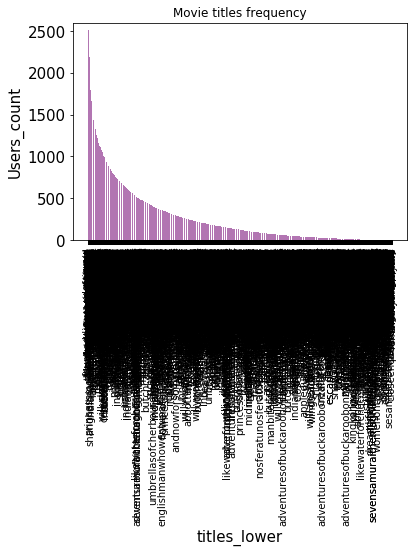

In [220]:
#Plotting movie titles frequency to idenfity those titles that represent the weakest features in out LDA model 
#to improve our topic modelling results 

height = titles_table['Users_count']
bars = titles_table['titles_lower']
y_pos = np.arange(len(bars))

# Create bars and choose color
plt.bar(y_pos, height, color = (0.5,0.1,0.5,0.6))
 
# Add title and axis names
plt.title('Movie titles frequency')
plt.xticks(size = 10)
plt.yticks(size = 15)
plt.xlabel('titles_lower', size = 15)
plt.ylabel('Users_count', size = 15)
 
# Limits for the Y axis
plt.ylim(0,2600)
 
# Create names
plt.xticks(y_pos, bars, rotation=90)
 
# Show graphic
plt.show()


In [221]:
#Find median and quartiles of user_count column to decide threshold where to remove the weakest features in our dataset.
#I will remove any user counts with values under 100 based on quartile 1 and median diplayed here

titles_table['Users_count'].quantile([0.25,0.5,0.75])

0.25     32
0.50    122
0.75    352
Name: Users_count, dtype: object

In [222]:
#Drop rows where user count is less than 100
titles_subtable = titles_table[titles_table['Users_count'] >= 100]

#Checking
#titles_subtable['Users_count'].min()
titles_subtable[['titles_lower', 'Users_count']].sort_values('Users_count',ascending=True).head(5)

,titles_lower,Users_count
2712,bound,100
25,titanic,100
1264,closeencountersofthethirdkind,100
431,pi,100
1602,benhur,100


# LDA in Gensim II

In [223]:
#Tuning model with a subset of my data (titles_subtable) instead of the whole set (titles_freqg)


df_LDAII= pd.DataFrame({'titles_lower': titles_subtable['titles_lower']})

cvII = CountVectorizer(binary = False)

docsII = cv.fit_transform(titles_subtable['titles_lower'].dropna())

#Build a mapping of numerical ID to word
id2wordII = dict(enumerate(cv.get_feature_names()))

id2wordII

{0: '101dalmatians',
 1: '13thwarriorthe',
 2: '20000leaguesunderthesea',
 3: '2010',
 4: '28days',
 5: '2daysinthevalley',
 6: '7thvoyageofsinbadthe',
 7: 'abbottandcostellomeetfrankenstein',
 8: 'absentmindedprofessorthe',
 9: 'absolutepower',
 10: 'abyssthe',
 11: 'addamsfamilythe',
 12: 'addamsfamilyvalues',
 13: 'adventuresinbabysitting',
 14: 'adventuresofbuckaroobonzaiacrossthe8thdimensionthe',
 15: 'adventuresofpriscillaqueenofthedesertthe',
 16: 'adventuresofrobinhoodthe',
 17: 'africanqueenthe',
 18: 'ageofinnocencethe',
 19: 'agnesofgod',
 20: 'airforceone',
 21: 'airplane',
 22: 'airport',
 23: 'akira',
 24: 'aladdin',
 25: 'aladdinandthekingofthieves',
 26: 'albinoalligator',
 27: 'aliceinwonderland',
 28: 'alien',
 29: 'aliennation',
 30: 'aliens',
 31: 'alien³',
 32: 'alive',
 33: 'allabouteve',
 34: 'alldogsgotoheaven',
 35: 'allquietonthewesternfront',
 36: 'almostfamous',
 37: 'amadeus',
 38: 'americanbeauty',
 39: 'americangraffiti',
 40: 'americanpie',
 41: 'america

In [225]:
#We convert our word-matrix into gensim's format
corpusI = Sparse2Corpus(docs, documents_columns = False)

lda_modelII = LdaModel(corpus = corpus, id2word = id2word, num_topics = 5, iterations = 100000)
lda_modelII.show_topics()

2018-08-05 12:02:58,948 : INFO : using symmetric alpha at 0.2
2018-08-05 12:02:58,950 : INFO : using symmetric eta at 0.2
2018-08-05 12:02:58,952 : INFO : using serial LDA version on this node
2018-08-05 12:02:58,954 : INFO : running online (single-pass) LDA training, 5 topics, 1 passes over the supplied corpus of 1905 documents, updating model once every 1905 documents, evaluating perplexity every 1905 documents, iterating 100000x with a convergence threshold of 0.001000
2018-08-05 12:02:58,955 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2018-08-05 12:02:59,397 : INFO : -10.656 per-word bound, 1613.0 perplexity estimate based on a held-out corpus of 1905 documents with 1902 words
2018-08-05 12:02:59,397 : INFO : PROGRESS: pass 0, at document #1905/1905
2018-08-05 12:02:59,711 : INFO : topic #0 (0.200): 0.013*"americanbeauty" + 0.013*"babe" + 0.012*"wizardofozthe" + 0.010*"shakespeareinlove" + 0.00

[(0,
  '0.013*"americanbeauty" + 0.013*"babe" + 0.012*"wizardofozthe" + 0.010*"shakespeareinlove" + 0.008*"closeencountersofthethirdkind" + 0.008*"willow" + 0.008*"shawshankredemptionthe" + 0.008*"totalrecall" + 0.008*"firmthe" + 0.008*"galaxyquest"'),
 (1,
  '0.015*"sixthsensethe" + 0.011*"titanic" + 0.011*"meninblack" + 0.010*"princessbridethe" + 0.010*"2010" + 0.008*"batman" + 0.008*"asgoodasitgets" + 0.008*"christmasstorya" + 0.007*"oneflewoverthecuckoosnest" + 0.007*"lethalweapon3"'),
 (2,
  '0.009*"jaws" + 0.009*"superman" + 0.009*"fargo" + 0.009*"airplane" + 0.008*"amadeus" + 0.008*"titanae" + 0.008*"contact" + 0.008*"ettheextraterrestrial" + 0.008*"willywonkaandthechocolatefactory" + 0.008*"diehard2"'),
 (3,
  '0.012*"indianajonesandthetempleofdoom" + 0.009*"big" + 0.009*"jurassicpark" + 0.009*"foryoureyesonly" + 0.009*"abyssthe" + 0.009*"lethalweapon" + 0.007*"schindlerslist" + 0.007*"madmax2akatheroadwarrior" + 0.007*"rockyhorrorpictureshowthe" + 0.007*"bladerunner"'),
 (4,
 

In [226]:
#Evaluating model fit
num_topics = 5
K = num_topics
num_words_per_topic = 3
for ti, topic in enumerate(lda_modelII.show_topics(num_topics, num_words_per_topic)):
    print("Topic: %d" % (ti))
    print (topic)
    print()
    
    

Topic: 0
(0, '0.013*"americanbeauty" + 0.013*"babe" + 0.012*"wizardofozthe"')

Topic: 1
(1, '0.015*"sixthsensethe" + 0.011*"titanic" + 0.011*"meninblack"')

Topic: 2
(2, '0.009*"jaws" + 0.009*"superman" + 0.009*"fargo"')

Topic: 3
(3, '0.012*"indianajonesandthetempleofdoom" + 0.009*"big" + 0.009*"jurassicpark"')

Topic: 4
(4, '0.016*"silenceofthelambsthe" + 0.012*"matrixthe" + 0.012*"indianajonesandthelastcrusade"')



# Visualizing LDA model 

http://intelligentonlinetools.com/blog/2017/01/22/data-visualization-visualizing-an-lda-model-using-python/

In [227]:
# Get Per-topic title probability matrix:

topicWordProbMat = lda_modelI.print_topics(K)

print (topicWordProbMat) 
 
columns = ['0','1','2','3','4']
df1 = pd.DataFrame(columns = columns)
pd.set_option('display.width', 1000)

2018-08-05 12:03:13,143 : INFO : topic #0 (0.200): 0.013*"silenceofthelambsthe" + 0.012*"indianajonesandthelastcrusade" + 0.010*"senseandsensibility" + 0.009*"toystory2" + 0.009*"indianajonesandthetempleofdoom" + 0.009*"asgoodasitgets" + 0.009*"robocop" + 0.009*"abyssthe" + 0.009*"bugslifea" + 0.009*"beautyandthebeast"
2018-08-05 12:03:13,145 : INFO : topic #1 (0.200): 0.011*"titanic" + 0.009*"sneakers" + 0.009*"untouchablesthe" + 0.009*"fifthelementthe" + 0.009*"terminatorthe" + 0.009*"independencedayid4" + 0.007*"americanbeauty" + 0.007*"chickenrun" + 0.007*"diehard2" + 0.007*"executivedecision"
2018-08-05 12:03:13,147 : INFO : topic #2 (0.200): 0.015*"sixthsensethe" + 0.013*"schindlerslist" + 0.013*"shawshankredemptionthe" + 0.013*"oneflewoverthecuckoosnest" + 0.010*"shakespeareinlove" + 0.010*"meninblack" + 0.010*"jurassicpark" + 0.008*"fugitivethe" + 0.008*"willow" + 0.008*"foryoureyesonly"
2018-08-05 12:03:13,148 : INFO : topic #3 (0.200): 0.009*"conair" + 0.009*"raisingarizona" 

[(0, '0.013*"silenceofthelambsthe" + 0.012*"indianajonesandthelastcrusade" + 0.010*"senseandsensibility" + 0.009*"toystory2" + 0.009*"indianajonesandthetempleofdoom" + 0.009*"asgoodasitgets" + 0.009*"robocop" + 0.009*"abyssthe" + 0.009*"bugslifea" + 0.009*"beautyandthebeast"'), (1, '0.011*"titanic" + 0.009*"sneakers" + 0.009*"untouchablesthe" + 0.009*"fifthelementthe" + 0.009*"terminatorthe" + 0.009*"independencedayid4" + 0.007*"americanbeauty" + 0.007*"chickenrun" + 0.007*"diehard2" + 0.007*"executivedecision"'), (2, '0.015*"sixthsensethe" + 0.013*"schindlerslist" + 0.013*"shawshankredemptionthe" + 0.013*"oneflewoverthecuckoosnest" + 0.010*"shakespeareinlove" + 0.010*"meninblack" + 0.010*"jurassicpark" + 0.008*"fugitivethe" + 0.008*"willow" + 0.008*"foryoureyesonly"'), (3, '0.009*"conair" + 0.009*"raisingarizona" + 0.009*"fishcalledwandaa" + 0.009*"firmthe" + 0.007*"deadpoetssociety" + 0.007*"princeofegyptthe" + 0.007*"goodwillhunting" + 0.005*"wizardofozthe" + 0.005*"americanbeauty" 

In [228]:
# I resized the matrix to 48 rows to match number of titles in lda_model
zz = np.zeros(shape=(48,K))

last_number=0
DC={}

for x in range (10):
  data = pd.DataFrame({columns[0]:"",
                     columns[1]:"",
                     columns[2]:"",
                     columns[3]:"",
                     columns[4]:"",
                                                                                 
                   
                    },index=[0])
  df1=df1.append(data,ignore_index=True)   


In [229]:
#Looping through topics within
for line in topicWordProbMat:

    tp, w = line
    probs=w.split("+")
    y=0
    for pr in probs:
               
        a=pr.split("*")
        df1.iloc[y,tp] = a[1]
       
        if a[1] in DC:
           zz[DC[a[1]]][tp]=a[0]
        else:
           zz[last_number][tp]=a[0]
           DC[a[1]]=last_number
           last_number=last_number+1
        y=y+1


IndexError: index 48 is out of bounds for axis 0 with size 48

In [230]:
#Show matrix probability data
print (zz)

[[0.013 0.    0.    0.    0.   ]
 [0.012 0.    0.    0.    0.   ]
 [0.01  0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.009 0.    0.    0.    0.   ]
 [0.    0.011 0.    0.    0.   ]
 [0.    0.009 0.    0.    0.   ]
 [0.    0.009 0.    0.    0.   ]
 [0.    0.009 0.    0.    0.   ]
 [0.    0.009 0.    0.    0.   ]
 [0.    0.009 0.    0.    0.   ]
 [0.    0.007 0.    0.005 0.   ]
 [0.    0.007 0.    0.    0.   ]
 [0.    0.007 0.    0.    0.   ]
 [0.    0.007 0.    0.    0.   ]
 [0.    0.    0.015 0.    0.   ]
 [0.    0.    0.013 0.    0.   ]
 [0.    0.    0.013 0.    0.   ]
 [0.    0.    0.013 0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0.01  0.    0.   ]
 [0.    0.    0.008 0.    0.   ]
 [0.    0.    0.008 0.    0.   ]
 [0.    0.    0.008 0.    0.   ]
 [0.    0.

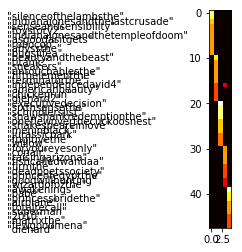

In [231]:
#Show titles theme heatmap

zz=np.resize(zz,(len(DC.keys()),zz.shape[1]))

for val, key in enumerate(DC.keys()):
        plt.text(-45, val + 1, key,
                 horizontalalignment='left',
                 verticalalignment='center'
                 )
plt.imshow(zz, cmap='hot', interpolation='nearest')
plt.show()

# I do not find themes meaningful regardless of using the whole data set or using a subset. My probability matrix and heat map visualization suggest very low probabilities of titles within themes. I am wondering if I should use the whole list of titles (more than 1 entry per title) instead of the list of unique titles from frequency table? Suggestions? Any other model that I could try? 

# Trying TF-IDF

Term Frequency * Inverse Document Frequency, Tf-Idf expects a bag-of-words (integer values) training corpus during initialization. During transformation, it will take a vector and return another vector of the same dimensionality, except that features which were rare in the training corpus will have their value increased. It therefore converts integer-valued vectors into real-valued ones, while leaving the number of dimensions intact. It can also optionally normalize the resulting vectors to (Euclidean) unit length.


In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.[1] It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general. Tf-idf is one of the most popular term-weighting schemes today; 83% of text-based recommender systems in digital libraries use tf-idf.[2]

Variations of the tf–idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query. tf–idf can be successfully used for stop-words filtering in various subject fields, including text summarization and classification.

One of the simplest ranking functions is computed by summing the tf–idf for each query term; many more sophisticated ranking functions are variants of this simple model.https://en.wikipedia.org/wiki/Tf%E2%80%93idf

#Will try to implement model as per info here:
https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3

In [233]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [329]:
#Recovering original dataframe for transfomation purposes
titles_trans.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3512 entries, 2651 to 2039
Data columns (total 3 columns):
titles_lower    3512 non-null object
Users_count     3512 non-null object
word            1 non-null object
dtypes: object(3)
memory usage: 269.8+ KB


In [275]:
# I am getting inspiration from https://github.com/mayank408/TFIDF/blob/master/Sklearn%20TFIDF.ipynb
#https://medium.freecodecamp.org/how-to-process-textual-data-using-tf-idf-in-python-cd2bbc0a94a3
    
#Importing module
from sklearn.feature_extraction.text import TfidfVectorizer

In [276]:
#Initializing the model
tfidf = TfidfVectorizer()

In [348]:
#Extracting movie titles from dataframe into series
cols2 = list(titles_trans['titles_lower'].iloc[0:])
cols2 = [str(x) for x in cols2]
print([item for item in cols2])

['misérables les ', 'superman ', 'babes in toyland ', 'brady bunch movie the ', 'four weddings and a funeral ', 'titanic ', 'house of dracula ', 'notting hill ', 'untouchables the ', 'hardboiled lashou shentan ', 'bonnie and clyde ', 'all quiet on the western front ', 'princess mononoke the mononoke hime ', 'thing from another world the ', 'strangers on a train ', 'election ', 'big ', 'where the heart is ', 'sister act ', 'running man the ', 'stigmata ', 'hercules ', 'time to kill a ', 'raiders of the lost ark ', 'james and the giant peach ', 'reality bites ', 'who framed roger rabbit ', 'boys dont cry ', 'being john malkovich ', 'midnight run ', 'shanghai triad yao a yao yao dao waipo qiao ', 'prizzis honor ', 'seven se7en ', 'dead poets society ', 'hunchback of notre dame the ', 'world is not enough the ', 'wild wild west ', 'omega man the ', 'crying game the ', 'indiana jones and the temple of doom ', 'men in black ', 'life is beautiful la vita è bella ', 'guess whos coming to dinne

In [350]:
#Fitting the model
response = tfidf.fit_transform([item for item in cols2])

In [351]:
#Running the model while iterating through series of titles to obtain term frequency

feature_names = tfidf.get_feature_names()
for col in response.nonzero()[1]:
    print (feature_names[col], ' - ', response[0, col])

misérables  -  0.7210346272119993
les  -  0.6928990304230865
superman  -  0.0
babes  -  0.0
in  -  0.0
toyland  -  0.0
brady  -  0.0
bunch  -  0.0
movie  -  0.0
the  -  0.0
four  -  0.0
weddings  -  0.0
and  -  0.0
funeral  -  0.0
titanic  -  0.0
house  -  0.0
of  -  0.0
dracula  -  0.0
notting  -  0.0
hill  -  0.0
the  -  0.0
untouchables  -  0.0
hardboiled  -  0.0
lashou  -  0.0
shentan  -  0.0
and  -  0.0
bonnie  -  0.0
clyde  -  0.0
the  -  0.0
all  -  0.0
quiet  -  0.0
on  -  0.0
western  -  0.0
front  -  0.0
the  -  0.0
princess  -  0.0
mononoke  -  0.0
hime  -  0.0
the  -  0.0
thing  -  0.0
from  -  0.0
another  -  0.0
world  -  0.0
on  -  0.0
strangers  -  0.0
train  -  0.0
election  -  0.0
big  -  0.0
the  -  0.0
where  -  0.0
heart  -  0.0
is  -  0.0
sister  -  0.0
act  -  0.0
the  -  0.0
running  -  0.0
man  -  0.0
stigmata  -  0.0
hercules  -  0.0
time  -  0.0
to  -  0.0
kill  -  0.0
the  -  0.0
of  -  0.0
raiders  -  0.0
lost  -  0.0
ark  -  0.0
the  -  0.0
and  -  0.0
jam

darkness  -  0.0
the  -  0.0
and  -  0.0
beauty  -  0.0
beast  -  0.0
the  -  0.0
big  -  0.0
chill  -  0.0
green  -  0.0
fried  -  0.0
tomatoes  -  0.0
benhur  -  0.0
unforgiven  -  0.0
splash  -  0.0
hard  -  0.0
die  -  0.0
superman  -  0.0
hamlet  -  0.0
cinderella  -  0.0
sixteen  -  0.0
candles  -  0.0
the  -  0.0
shawshank  -  0.0
redemption  -  0.0
space  -  0.0
office  -  0.0
henry  -  0.0
gladiator  -  0.0
thelma  -  0.0
louise  -  0.0
at  -  0.0
fast  -  0.0
times  -  0.0
ridgemont  -  0.0
high  -  0.0
at  -  0.0
weekend  -  0.0
bernies  -  0.0
the  -  0.0
matrix  -  0.0
nineteen  -  0.0
eightyfour  -  0.0
kramer  -  0.0
vs  -  0.0
meteor  -  0.0
the  -  0.0
matrix  -  0.0
for  -  0.0
love  -  0.0
or  -  0.0
money  -  0.0
the  -  0.0
joy  -  0.0
luck  -  0.0
club  -  0.0
go  -  0.0
the  -  0.0
blues  -  0.0
brothers  -  0.0
the  -  0.0
and  -  0.0
beauty  -  0.0
beast  -  0.0
the  -  0.0
last  -  0.0
emperor  -  0.0
deliverance  -  0.0
the  -  0.0
of  -  0.0
mask  -  0.0
zor

dead  -  0.0
night  -  0.0
living  -  0.0
batman  -  0.0
absolute  -  0.0
power  -  0.0
sleepy  -  0.0
hollow  -  0.0
hard  -  0.0
die  -  0.0
the  -  0.0
and  -  0.0
of  -  0.0
indiana  -  0.0
jones  -  0.0
temple  -  0.0
doom  -  0.0
the  -  0.0
black  -  0.0
hole  -  0.0
moonraker  -  0.0
king  -  0.0
kong  -  0.0
superman  -  0.0
iii  -  0.0
deep  -  0.0
impact  -  0.0
notting  -  0.0
hill  -  0.0
pocahontas  -  0.0
iq  -  0.0
gremlins  -  0.0
the  -  0.0
terminator  -  0.0
total  -  0.0
recall  -  0.0
the  -  0.0
thing  -  0.0
do  -  0.0
right  -  0.0
the  -  0.0
under  -  0.0
down  -  0.0
rescuers  -  0.0
highlander  -  0.0
vacation  -  0.0
the  -  0.0
howard  -  0.0
duck  -  0.0
the  -  0.0
running  -  0.0
man  -  0.0
thunderball  -  0.0
the  -  0.0
and  -  0.0
of  -  0.0
indiana  -  0.0
jones  -  0.0
temple  -  0.0
doom  -  0.0
christmas  -  0.0
vacation  -  0.0
rear  -  0.0
window  -  0.0
ladyhawke  -  0.0
sneakers  -  0.0
cape  -  0.0
fear  -  0.0
the  -  0.0
sixth  -  0.0
se

schindlers  -  0.0
list  -  0.0
club  -  0.0
fight  -  0.0
of  -  0.0
little  -  0.0
shop  -  0.0
horrors  -  0.0
the  -  0.0
and  -  0.0
james  -  0.0
giant  -  0.0
peach  -  0.0
rocky  -  0.0
iii  -  0.0
tron  -  0.0
platoon  -  0.0
of  -  0.0
frankenstein  -  0.0
son  -  0.0
run  -  0.0
lola  -  0.0
rennt  -  0.0
dark  -  0.0
city  -  0.0
scream  -  0.0
for  -  0.0
your  -  0.0
eyes  -  0.0
only  -  0.0
screwed  -  0.0
the  -  0.0
world  -  0.0
is  -  0.0
not  -  0.0
enough  -  0.0
the  -  0.0
of  -  0.0
grapes  -  0.0
wrath  -  0.0
serpico  -  0.0
the  -  0.0
of  -  0.0
dead  -  0.0
night  -  0.0
living  -  0.0
schindlers  -  0.0
list  -  0.0
the  -  0.0
terminator  -  0.0
in  -  0.0
sleepless  -  0.0
seattle  -  0.0
seven  -  0.0
se7en  -  0.0
dangerous  -  0.0
liaisons  -  0.0
dead  -  0.0
off  -  0.0
better  -  0.0
metal  -  0.0
full  -  0.0
jacket  -  0.0
the  -  0.0
fifth0.0
of  -  0.0
silence  -  0.0
lambs  -  0.0
apollo  -  0.0
13  -  0.0
ed  -  0.0
wood  -  0.0
the  -  0.0


as  -  0.0
gets  -  0.0
speed  -  0.0
cocoon  -  0.0
and  -  0.0
sex  -  0.0
lies  -  0.0
videotape  -  0.0
batman  -  0.0
mars  -  0.0
attacks  -  0.0
duck  -  0.0
soup  -  0.0
the  -  0.0
santa  -  0.0
clause  -  0.0
the  -  0.0
of  -  0.0
story  -  0.0
us  -  0.0
ronin  -  0.0
to  -  0.0
goes  -  0.0
mr  -  0.0
smith  -  0.0
washington  -  0.0
trading  -  0.0
places  -  0.0
jaws  -  0.0
robocop  -  0.0
the  -  0.0
arrival  -  0.0
the  -  0.0
fugitive  -  0.0
lethal  -  0.0
weapon  -  0.0
the  -  0.0
of  -  0.0
grapes  -  0.0
wrath  -  0.0
american  -  0.0
beauty  -  0.0
exotica  -  0.0
who  -  0.0
framed  -  0.0
roger  -  0.0
rabbit  -  0.0
willow  -  0.0
the  -  0.0
exorcist  -  0.0
rocky  -  0.0
iv  -  0.0
close  -  0.0
shave  -  0.0
the  -  0.0
man  -  0.0
who  -  0.0
knew  -  0.0
too  -  0.0
much  -  0.0
puppet  -  0.0
master  -  0.0
and  -  0.0
gods  -  0.0
monsters  -  0.0
the  -  0.0
of  -  0.0
village  -  0.0
damned  -  0.0
emma  -  0.0
doctor  -  0.0
dolittle  -  0.0
cinder

daddy  -  0.0
mad  -  0.0
max  -  0.0
beyond  -  0.0
thunderdome  -  0.0
rocky  -  0.0
anaconda  -  0.0
shanghai  -  0.0
noon  -  0.0
in  -  0.0
the  -  0.0
man  -  0.0
mask  -  0.0
iron  -  0.0
the  -  0.0
and  -  0.0
beauty  -  0.0
beast  -  0.0
wild  -  0.0
west  -  0.0
is  -  0.0
born  -  0.0
star  -  0.0
angelas  -  0.0
ashes  -  0.0
double  -  0.0
jeopardy  -  0.0
indochine  -  0.0
batman  -  0.0
what  -  0.0
dreams  -  0.0
may  -  0.0
come  -  0.0
primary  -  0.0
colors  -  0.0
hamlet  -  0.0
the  -  0.0
of  -  0.0
war  -  0.0
worlds  -  0.0
my  -  0.0
idaho  -  0.0
private  -  0.0
own  -  0.0
gladiator  -  0.0
antz  -  0.0
the  -  0.0
fugitive  -  0.0
otello  -  0.0
the  -  0.0
of  -  0.0
flight  -  0.0
navigator  -  0.0
foxfire  -  0.0
edward  -  0.0
scissorhands  -  0.0
goodfellas  -  0.0
superman  -  0.0
batman  -  0.0
returns  -  0.0
big  -  0.0
little  -  0.0
league  -  0.0
ulees  -  0.0
gold  -  0.0
dune  -  0.0
the  -  0.0
blues  -  0.0
brothers  -  0.060  -  0.0
seconds

shentan  -  0.0
man  -  0.0
renaissance  -  0.0
man  -  0.0
demolition  -  0.0
mr  -  0.0
hollands  -  0.0
opus  -  0.0
the  -  0.0
one  -  0.0
flew  -  0.0
over  -  0.0
cuckoos  -  0.0
nest  -  0.0
when  -  0.0
harry  -  0.0
met  -  0.0
sally  -  0.0
the  -  0.0
house  -  0.0
cider  -  0.0
rules  -  0.0
la  -  0.0
confidential  -  0.0
the  -  0.0
of  -  0.0
planet  -  0.0
apes  -  0.0
the  -  0.0
warrior  -  0.0
13th  -  0.0
the  -  0.0
muppets  -  0.0
manhattan  -  0.0
take  -  0.0
pulp  -  0.0
fiction  -  0.0
the  -  0.0
with  -  0.0
gone  -  0.0
wind  -  0.0
rush  -  0.0
hour  -  0.0
breakfast  -  0.0
at  -  0.0
tiffanys  -  0.0
major  -  0.0
payne  -  0.0
the  -  0.0
of  -  0.0
oz  -  0.0
wizard  -  0.0
the  -  0.0
all  -  0.0
way  -  0.0
jingle  -  0.0
casino  -  0.0
the  -  0.0
of  -  0.0
legends  -  0.0
fall  -  0.0
kids  -  0.0
thing  -  0.0
swamp  -  0.0
striptease  -  0.0
aliens  -  0.0
the  -  0.0
kids  -  0.0
honey  -  0.0
shrunk  -  0.0
texas  -  0.0
happy  -  0.0
time  -

of  -  0.0
days  -  0.0
last  -  0.0
disco  -  0.0
the  -  0.0
fly  -  0.0
lies  -  0.0
secrets  -  0.0
roman  -  0.0
holiday  -  0.0
key  -  0.0
largo  -  0.0
the  -  0.0
exorcist  -  0.0
moonstruck  -  0.0
metropolis  -  0.0
xmen  -  0.0
henry  -  0.0
being  -  0.0
john  -  0.0
malkovich  -  0.0
desperado  -  0.0
kramer  -  0.0
vs  -  0.0
the  -  0.0
fugitive  -  0.0
funny  -  0.0
face  -  0.0
the  -  0.0
of  -  0.0
adventures  -  0.0
buckaroo  -  0.0
bonzai  -  0.0
across  -  0.0
8th  -  0.0
dimension  -  0.0
the  -  0.0
spanish  -  0.0
prisoner  -  0.0
time  -  0.0
bandits  -  0.0
chinatown  -  0.0
go  -  0.0
the  -  0.0
shawshank  -  0.0
redemption  -  0.0
the  -  0.0
english  -  0.0
patient  -  0.0
westworld  -  0.0
the  -  0.0
last  -  0.0
emperor  -  0.0
showgirls  -  0.0
mad  -  0.0
max  -  0.0
beyond  -  0.0
thunderdome  -  0.0
day  -  0.0
groundhog  -  0.0
the  -  0.0
matrix  -  0.0
is  -  0.0
life  -  0.0
beautiful  -  0.0
la  -  0.0
vita  -  0.0
bella  -  0.0
saturn  -  0.

# I believe there's something not 100% ok with my loop (above) or my data is terrible :( my frequencies are really low. Unsure what else to look at to ensure meaningful themes...

# Making a prediction

In [ ]:
#lda_model.predict (double tab)

# Model interpretation

# Improvement areas

# Model optimisation and associated costs/benefits